## **Accounting Fraud Detection using Normalizing-Flows**

In [1]:
!pip install --upgrade nflows matplotlib seaborn --quiet
#!pip install pykan
!pip install git+https://github.com/Blealtan/efficient-kan.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 74.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:010

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
import os
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms import (
    LULinear,
    PiecewiseRationalQuadraticCouplingTransform,
    AffineCouplingTransform
)
from nflows.transforms.normalization import ActNorm
from nflows.utils import create_alternating_binary_mask
from efficient_kan import KAN as EfficientKAN
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def generate_synthetic_data(n_samples_normal=1000, n_samples_fraud=50):
    """Generates synthetic normal and fraudulent financial data."""
    mean_normal = np.array([0.5, 0.2, 0.7, 0.4, 0.6])
    cov_normal = np.array([
        [0.02, 0.01, 0.005, 0.005, 0.005],
        [0.01, 0.03, 0.01, 0.005, 0.005],
        [0.005, 0.01, 0.02, 0.005, 0.005],
        [0.005, 0.005, 0.005, 0.03, 0.01],
        [0.005, 0.005, 0.005, 0.01, 0.02]
    ])
    normal_data = np.random.multivariate_normal(mean_normal, cov_normal, n_samples_normal)

    mean_fraud = np.array([0.1, 0.8, 0.2, 0.9, 0.1])
    cov_fraud = np.array([
        [0.05, -0.02, 0.01, -0.03, 0.01],
        [-0.02, 0.06, -0.01, 0.04, -0.01],
        [0.01, -0.01, 0.04, -0.02, 0.01],
        [-0.03, 0.04, -0.02, 0.07, -0.02],
        [0.01, -0.01, 0.01, -0.02, 0.05]
    ])
    fraud_data = np.random.multivariate_normal(mean_fraud, cov_fraud, n_samples_fraud)
    return normal_data, fraud_data

"""
normal_data, fraud_data = generate_synthetic_data()
X_train = normal_data.astype(np.float32)
X_test = np.vstack([normal_data[:200], fraud_data]).astype(np.float32)
y_test = np.hstack([np.zeros(200), np.ones(fraud_data.shape[0])])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

'\nnormal_data, fraud_data = generate_synthetic_data()\nX_train = normal_data.astype(np.float32)\nX_test = np.vstack([normal_data[:200], fraud_data]).astype(np.float32)\ny_test = np.hstack([np.zeros(200), np.ones(fraud_data.shape[0])])\n\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transform(X_test)\n'

In [25]:
import pandas as pd

df = pd.read_csv(r"/kaggle/input/accounting-fraud/uscecchini28.csv")
print(df.head())
print("\nOriginal Skewness of Features:")
print(df.skew())

# Check for infinite values in the entire dataframe
inf_counts = df.isin([np.inf, -np.inf]).sum()
print("Columns with infinite values:")
print(inf_counts[inf_counts > 0])

# df.replace([np.inf, -np.inf], np.nan, inplace=True)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


   fyear  gvkey    sich  insbnk  understatement  option  p_aaer  new_p_aaer  \
0   1990   1009  3460.0       0               0       0     NaN         NaN   
1   1990   1011  4841.0       0               0       0     NaN         NaN   
2   1990   1017  3812.0       0               0       0     NaN         NaN   
3   1990   1021  3861.0       0               0       0     NaN         NaN   
4   1990   1028  7385.0       0               0       0     NaN         NaN   

   misstate     act  ...  soft_assets     ch_cs     ch_cm    ch_roa  issue  \
0         0  10.047  ...     0.312448  0.095082  0.082631 -0.019761      1   
1         0   1.247  ...     0.315904  0.188832 -0.211389 -0.117832      1   
2         0  55.040  ...     0.605342  0.097551 -0.105780  0.091206      1   
3         0  24.684  ...     0.793068 -0.005725 -0.249704  0.017545      1   
4         0  17.325  ...     0.869182 -0.231536 -1.674893 -0.466667      0   

         bm       dpi      reoa      EBIT    ch_fcf  
0 

In [4]:
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split

# --- raw variables and Benford's theoretical probabilities ---
raw_variables = ['at', 'ap', 'ceq', 'che', 'csho', 'dltt', 'dp', 'ni', 'ppegt',
                  'pstk', 're', 'rect', 'sale', 'lt', 'xint', 'ivao', 'dltis', 'sstk']

# Theoretical probabilities for digits 1-9
benford_probs = np.array([np.log10(1 + 1 / d) for d in range(1, 10)])

# --- function to calculate the Benford's Law Chi-squared statistic for a row ---
def calculate_benford_chi2(row):
    """Calculates the Chi-squared statistic for a given row based on Benford's Law."""

    # Extract first digits from the row's variables, excluding NaNs and zeros
    first_digits = [
        int(str(abs(x))[0]) for x in row[raw_variables]
        if pd.notna(x) and x != 0
    ]

    if not first_digits:
        return np.nan

    # Count the occurrences of each digit
    digit_counts = pd.Series(first_digits).value_counts().sort_index()

    # Create an observed counts array for all 9 digits
    observed = np.zeros(9)
    for i, count in digit_counts.items():
        if 1 <= i <= 9:
            observed[i-1] = count

    # Expected counts based on Benford's Law
    n = len(first_digits)
    expected = benford_probs * n

    # Calculate Chi-squared statistic, handling zero values
    expected_safe = expected + 1e-10
    chi2_stat = np.sum((observed - expected)**2 / expected_safe)

    return chi2_stat

# --- Add the new feature column to the DataFrame ---
# df['benford_chi2'] = df.apply(calculate_benford_chi2, axis=1)


In [26]:
from sklearn.model_selection import train_test_split

# Separate all normal and fraud data
df_normal = df[df['misstate'] == 0]
df_fraud = df[df['misstate'] == 1]

# Define features
features = ['act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 
            'ib', 'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 'ppegt', 'pstk', 're', 'rect', 'sale',
            'sstk', 'txp', 'txt', 'xint', 'prcc_f']

# Split the NORMAL data first into a training and a testing set
X_normal = df_normal[features].dropna()
y_normal = df_normal.loc[X_normal.index]['misstate']

X_train, X_test_normal, y_train, y_test_normal = train_test_split(
    X_normal, y_normal, test_size=0.05, random_state=42
)

lower_quantile = 0.01
upper_quantile = 0.99
# Store the bounds learned from the training data
bounds = {}
for col in X_train.columns:
    lower_bound = X_train[col].quantile(lower_quantile)
    upper_bound = X_train[col].quantile(upper_quantile)
    bounds[col] = (lower_bound, upper_bound)
    # Clip the training data
    X_train[col] = X_train[col].clip(lower_bound, upper_bound)

# Clip the test data using the bounds from the TRAINING data
for col in X_test_normal.columns:
    lower_bound, upper_bound = bounds[col]
    X_test_normal[col] = X_test_normal[col].clip(lower_bound, upper_bound)

pt = PowerTransformer(method='yeo-johnson')
scaler = StandardScaler()

X_train_transformed = pt.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train_transformed)

zero_variance_cols = X_train.columns[scaler.scale_ == 0]
if len(zero_variance_cols) > 0:
    print("Found columns with zero variance (standard deviation):")
    print(list(zero_variance_cols))
else:
    print("No columns with zero variance found.")

# Prepare the fraud data
X_test_fraud = df_fraud[features].dropna()
y_test_fraud = df_fraud.loc[X_test_fraud.index]['misstate']

# clip the fraud data using the bounds learned from the TRAINING data
for col in X_test_fraud.columns:
    if col in bounds:
        lower_bound, upper_bound = bounds[col]
        X_test_fraud[col] = X_test_fraud[col].clip(lower_bound, upper_bound)

# Transform normal test data and fraud test data
X_test_normal_transformed = pt.transform(X_test_normal)
X_test_normal_scaled = scaler.transform(X_test_normal_transformed)

X_test_fraud_transformed = pt.transform(X_test_fraud)
X_test_fraud_scaled = scaler.transform(X_test_fraud_transformed)

X_test_scaled = np.vstack([X_test_fraud_scaled, X_test_normal_scaled])
y_test = pd.concat([y_test_fraud, y_test_normal])

print("\nPreprocessing complete.")
print(f"Shape of the final scaled training data (X_train_scaled): {X_train_scaled.shape}")
print(f"Shape of the final scaled test data (X_test_scaled): {X_test_scaled.shape}")
print(f"Shape of the final test labels (y_test): {y_test.shape}")

No columns with zero variance found.

Preprocessing complete.
Shape of the final scaled training data (X_train_scaled): (137826, 28)
Shape of the final scaled test data (X_test_scaled): (8219, 28)
Shape of the final test labels (y_test): (8219,)


In [27]:
#pd.DataFrame(X_train_transformed).skew()
from scipy.stats import energy_distance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

mean_normal = np.mean(X_train_scaled, axis=0)
mean_fraud = np.mean(X_test_fraud_scaled, axis=0)

print(f"Mean of Normal Class (shape {mean_normal.shape}):\n{mean_normal}")
print(f"Mean of Fraud Class (shape {mean_fraud.shape}):\n{mean_fraud}")

cov_normal = np.cov(X_train_scaled, rowvar=False)
cov_fraud = np.cov(X_test_fraud_scaled, rowvar=False)

"""
print("\n--- Covariance Matrices ---")
print(f"Covariance of Normal Class (shape {cov_normal.shape}):\n{cov_normal}")
print(f"Covariance of Fraud Class (shape {cov_fraud.shape}):\n{cov_fraud}")

distance = energy_distance(X_train_scaled, X_test_fraud_scaled)

print(f"\n--- Energy Distance ---")
print(f"The Energy Distance between the normal and fraud classes is: {distance:.4f}")
"""

R_X_combined = np.vstack([X_train_scaled, X_test_fraud_scaled])

# Create corresponding labels: 0 for normal, 1 for fraud
R_y_normal = np.zeros(X_train_scaled.shape[0])
R_y_fraud = np.ones(X_test_fraud_scaled.shape[0])
R_y_combined = np.concatenate([R_y_normal, R_y_fraud])

R_X_train, R_X_test, R_y_train, R_y_test = train_test_split(
    R_X_combined, R_y_combined, test_size=0.5, stratify=R_y_combined, random_state=42
)

# Use a robust classifier like a Random Forest
R_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
R_classifier.fit(R_X_train, R_y_train)

R_probs = R_classifier.predict_proba(R_X_test)[:, 1]

# Calculate the Area Under the ROC Curve (AUC)
R_auc_score = roc_auc_score(R_y_test, R_probs)

print(f"\n--- Classifier Two-Sample Test ---")
print(f"AUC Score: {R_auc_score:.4f}")

if R_auc_score > 0.95:
    print("Interpretation: The distributions are very different (easily separable).")
elif R_auc_score > 0.6:
    print("Interpretation: The distributions are noticeably different.")
else:
    print("Interpretation: The distributions are very similar (hard to separate).")



Mean of Normal Class (shape (28,)):
[-1.74251190e-17 -1.14449006e-17  1.35070449e-17 -1.23728655e-17
  1.60847252e-17  8.76411309e-19  5.56778949e-18  1.35070449e-17
  2.62923393e-17  2.94886629e-17 -1.67033685e-17  3.29943081e-18
  3.95931697e-17  1.36101521e-17  2.18587291e-17  1.44350098e-17
 -1.60847252e-17 -3.29943081e-18  1.27337408e-17  3.09321638e-18
  1.75282262e-18  1.75282262e-18 -2.24773724e-17  1.64971541e-18
  2.84575907e-17  1.00013996e-17  2.48488383e-17 -3.57782029e-17]
Mean of Fraud Class (shape (28,)):
[ 0.62686782  0.54287647  0.57004248  0.35583408  0.47504417  0.5481387
  0.3458107   0.33785814  0.40297866  0.39368974  0.45286221 -0.03604202
  0.42054699  0.2645479   0.16025253  0.58386885  0.53466111 -0.05750773
  0.3604388   0.02490725  0.03633897  0.62992805  0.57971417  0.56922949
  0.32189184  0.12910228  0.39756763  0.59001675]

--- Classifier Two-Sample Test ---
AUC Score: 0.7919
Interpretation: The distributions are noticeably different.


In [29]:
print(f"Original training data shape: {X_train_scaled.shape}")

# Define a threshold for extreme values
threshold = 200

# Find the indices of all rows that contain a value exceeding the threshold
outlier_indices = np.where(np.abs(X_train_scaled) > threshold)[0]
outlier_indices = np.unique(outlier_indices)

print(f"Found {len(outlier_indices)} rows with extreme outlier values.")
X_train_scaled = np.delete(X_train_scaled, outlier_indices, axis=0)
print(f"New training data shape after filtering: {X_train_scaled.shape}")

Original training data shape: (137826, 28)
Found 0 rows with extreme outlier values.
New training data shape after filtering: (137826, 28)


In [38]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.SiLU(),
            nn.Linear(32, encoding_dim),
            nn.SiLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.SiLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# --- Autoencoder Training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_train_scaled.shape[1]
encoding_dim = 16 # Hyperparameter: dimension of the compressed representation
ae_epochs = 100
ae_batch_size = 256
ae_learning_rate = 1e-3

autoencoder = Autoencoder(input_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=ae_learning_rate)

X_train_tensor = torch.from_numpy(X_train_scaled.astype(np.float32))
train_dataset_ae = TensorDataset(X_train_tensor, X_train_tensor) # Input and target are the same
train_loader_ae = DataLoader(train_dataset_ae, batch_size=ae_batch_size, shuffle=True)

print("Starting Autoencoder training...")
for epoch in range(ae_epochs):
    autoencoder.train()
    train_loss = 0.0
    for data in train_loader_ae:
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_ae)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{ae_epochs}, Reconstruction Loss: {avg_train_loss:.6f}")

print("Autoencoder training finished.")

# --- Extract Features using the Trained Encoder ---
encoder = autoencoder.encoder
encoder.eval()

with torch.no_grad():
    X_train_encoded_tensor = encoder(torch.from_numpy(X_train_scaled.astype(np.float32)).to(device))
    X_test_encoded_tensor = encoder(torch.from_numpy(X_test_scaled.astype(np.float32)).to(device))

X_train_encoded = X_train_encoded_tensor.cpu().numpy()
X_test_encoded = X_test_encoded_tensor.cpu().numpy()

print(f"Original feature dimension: {input_dim}")
print(f"New encoded feature dimension: {X_train_encoded.shape[1]}")

Starting Autoencoder training...
Epoch 10/100, Reconstruction Loss: 0.022433
Epoch 20/100, Reconstruction Loss: 0.019124
Epoch 30/100, Reconstruction Loss: 0.017771
Epoch 40/100, Reconstruction Loss: 0.017175
Epoch 50/100, Reconstruction Loss: 0.016848
Epoch 60/100, Reconstruction Loss: 0.016539
Epoch 70/100, Reconstruction Loss: 0.016217
Epoch 80/100, Reconstruction Loss: 0.015818
Epoch 90/100, Reconstruction Loss: 0.015455
Epoch 100/100, Reconstruction Loss: 0.015236
Autoencoder training finished.
Original feature dimension: 28
New encoded feature dimension: 16


In [39]:
# Convert to PyTorch Tensors
X_train_tensor = torch.from_numpy(X_train_encoded.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test_encoded.astype(np.float32))

# Check for NaNs and infinite values in tensors
if torch.isnan(X_train_tensor).any() or torch.isinf(X_train_tensor).any():
    print("NaN or infinite values found in X_train_tensor!")
if torch.isnan(y_train_tensor).any() or torch.isinf(y_train_tensor).any():
    print("NaN or infinite values found in y_train_tensor!")
if torch.isnan(X_test_tensor).any() or torch.isinf(X_test_tensor).any():
    print("NaN or infinite values found in X_test_tensor!")

# Create datasets from the scaled tensors
train_dataset = TensorDataset(X_train_tensor)

# Create a validation split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

class ContextIgnoredMLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.SiLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.SiLU(),
            nn.Linear(hidden_features, out_features),
        )

    def forward(self, inputs, context=None):
        # We simply ignore the context and pass the inputs to our network
        return self.network(inputs)

#from kan import KAN # (pip install pykan)
from efficient_kan import KAN as EfficientKAN

class ContextIgnoredKAN(nn.Module):
    """
    A wrapper for a pykan.KAN model to make it compatible with nflows.
    It accepts and ignores the 'context' argument in its forward pass.
    """
    def __init__(self, in_features, out_features, hidden_layers=[128, 128], grid_size=3, spline_order=3):
        super().__init__()
        
        # Define the KAN architecture
        # width = [input_dim, hidden1_dim, hidden2_dim, ..., output_dim]
        width = [in_features, *hidden_layers, out_features]
        
        self.kan = EfficientKAN(
            width,
            grid_size=grid_size,
            spline_order=spline_order
        )

    def forward(self, inputs, context=None):
        # We simply ignore the context and pass the inputs to our KAN
        return self.kan(inputs)
        
def weights_init(m):
    """
    Applies Kaiming (He) normal initialization to linear layers.
    This helps prevent gradients from exploding or vanishing early in training.
    """
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# --- Define the Flow-based Model using nflows ---
def create_nflows_model(input_dim, num_layers=6, hidden_dim=256, device='cpu'):
    """Creates a RealNVP-style model using the nflows library."""
    base_dist = StandardNormal(shape=[input_dim])

    transform_net_create_fn = lambda in_features, out_features: ContextIgnoredKAN(
            in_features=in_features,
            out_features=out_features,
            hidden_layers=[hidden_dim, hidden_dim] 
    )

    def create_transform_net(in_features, out_features):
        network = ContextIgnoredKAN(
            in_features=in_features,
            out_features=out_features,
            hidden_layers=[hidden_dim, hidden_dim]
        )
        
        # ROBUST INITIALIZATION
        final_kan_layer = network.kan.layers[-1]
        torch.nn.init.normal_(final_kan_layer.base_weight, mean=0.0, std=0.01)
        torch.nn.init.normal_(final_kan_layer.spline_weight, mean=0.0, std=0.01)
        
        return network
    
    """
    transform_net_create_fn = lambda in_features, out_features: ContextIgnoredMLP(
        in_features=in_features,
        out_features=out_features,
        hidden_features=hidden_dim
    )
    """
    transforms = []
    mask = create_alternating_binary_mask(features=input_dim, even=True)
    for _ in range(num_layers):
        transforms.append(RandomPermutation(features=input_dim))
        transforms.append(ActNorm(features=input_dim))
        transforms.append(
            AffineCouplingTransform(
                mask=mask,
                transform_net_create_fn=create_transform_net
            )
        )
        mask = 1 - mask # Flip the mask for the next layer
        
        """
        transforms.append(
            MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                features=input_dim,
                hidden_features=hidden_dim,
                # These are sensible defaults for the spline transform
                num_bins=8,
                tails='linear',
                tail_bound=5,
            )
        )
        """

    transform = CompositeTransform(transforms)
    flow = Flow(transform, base_dist)
    return flow

In [40]:
# --- Forensic Debugging Cell ---
print("--- Starting Forensic Debugging ---")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = TensorDataset(X_train_tensor)

# Use the exact same (simplified) settings that are failing
input_dim = X_train_encoded.shape[1]
num_coupling_layers = 12
hidden_dim = 256
batch_size = 256 

# Re-create the DataLoader to ensure we get a consistent first batch
# NOTE: Set shuffle=False to make the test repeatable.
train_loader_debug = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Get the VERY FIRST batch of data
try:
    first_batch = next(iter(train_loader_debug))[0]
    print(f"\nSuccessfully loaded one batch of size: {first_batch.shape}")
except StopIteration:
    print("Error: DataLoader is empty. Check your train_dataset.")
    # Stop here if there's no data

# Inspect the batch itself for any issues post-scaling and loading
print(f"Batch Stats: Min={first_batch.min():.4f}, Max={first_batch.max():.4f}, Mean={first_batch.mean():.4f}")
if torch.isnan(first_batch).any() or torch.isinf(first_batch).any():
    print("!!! FATAL ERROR: The batch itself contains NaNs or Infs before entering the model!")
else:
    print("Batch data appears clean (no NaNs or Infs).")

# Create a fresh model instance and run a single forward pass
model_debug = create_nflows_model(input_dim, num_coupling_layers, hidden_dim)
model_debug.to(device)
first_batch = first_batch.to(device)
#model_debug.double()
model_debug.apply(weights_init)
model_debug.eval() # Set to evaluation mode for a clean forward pass

print("\n--- Running Forward Pass on Single Batch ---")
with torch.no_grad():
    try:
        log_probs = model_debug.log_prob(inputs=first_batch)

        # 6. Check for issues in the model's output
        nan_mask = torch.isnan(log_probs)
        inf_mask = torch.isinf(log_probs)

        if nan_mask.any():
            print(f"FAILURE: Found {nan_mask.sum()} NaN(s) in the log_prob output!")
            # Find the specific row(s) in the batch that caused the NaN
            problem_indices = nan_mask.nonzero(as_tuple=True)[0]
            print(f"Data row at index {problem_indices[0]} in the batch caused the NaN.")
            print("\n--- Problematic Data Point ---")
            print(first_batch[problem_indices[0]])
            print("------------------------------")

        elif inf_mask.any():
            print(f"FAILURE: Found {inf_mask.sum()} Inf(s) in the log_prob output!")
            problem_indices = inf_mask.nonzero(as_tuple=True)[0]
            print(f"Data row at index {problem_indices[0]} in the batch caused the Inf.")
            print("\n--- Problematic Data Point ---")
            print(first_batch[problem_indices[0]])
            print("------------------------------")
        else:
            print(f"SUCCESS: The forward pass is clean.")
            print(f"Log Probs Stats: Min={log_probs.min():.4f}, Max={log_probs.max():.4f}")
            print("This suggests the NaN may be occurring in the backward pass (gradient calculation).")


    except Exception as e:
        print(f"\nAn exception occurred during the forward pass: {e}")

# Clean up to avoid interfering with the main training loop
del model_debug, train_loader_debug

--- Starting Forensic Debugging ---

Successfully loaded one batch of size: torch.Size([256, 16])
Batch Stats: Min=0.5725, Max=11.5304, Mean=3.4911
Batch data appears clean (no NaNs or Infs).

--- Running Forward Pass on Single Batch ---
SUCCESS: The forward pass is clean.
Log Probs Stats: Min=-115.7932, Max=-38.8974
This suggests the NaN may be occurring in the backward pass (gradient calculation).


In [41]:
import torch.nn as nn

# --- Training the Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_train_encoded.shape[1]
num_coupling_layers = 24
hidden_dim = 256
learning_rate = 1e-3
batch_size = 512
epochs = 100
patience = 10 # For early stopping
best_model_path = "best_model.pth"
weight_decay = 1e-5

if torch.isnan(torch.tensor(X_train_scaled)).any():
    raise ValueError("Input data contains NaN values. Please clean the data before training.")
else:
    print("Data integrity check passed: No NaN values found in input data.")

model = create_nflows_model(input_dim, num_coupling_layers, hidden_dim)
#model.double()
model.apply(weights_init)

if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model.to(device)
print(f"Using device: {device}")

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Create DataLoaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print("Starting model training...")

best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for (batch,) in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        if isinstance(model, nn.DataParallel):
            loss = -model.module.log_prob(inputs=batch).mean()
        else:
            loss = -model.log_prob(inputs=batch).mean()

        if torch.isnan(loss):
            print("NaN loss detected. Stopping training.")
            break

        loss.backward()

        # gradient clipping for stabilization
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

        optimizer.step()
        train_loss += loss.item()

    if torch.isnan(loss): # Break outer loop if NaN was detected
        break

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (batch,) in val_loader:
            batch = batch.to(device)
            if isinstance(model, nn.DataParallel):
                loss = -model.module.log_prob(inputs=batch).mean()
            else:
                loss = -model.log_prob(inputs=batch).mean()
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss is None or torch.isnan(torch.tensor(avg_val_loss)):
        print(f"Validation loss is None at epoch {epoch + 1}. Stopping training.")
        break

    # Early stopping and best model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        state_to_save = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state_to_save, best_model_path)
        early_stopping_counter = 0
        print(f"  -> New best model saved with val_loss: {best_val_loss:.4f}")
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
        break

print("\nTraining finished.")


Data integrity check passed: No NaN values found in input data.
Using device: cuda
Starting model training...
  -> New best model saved with val_loss: 7.0209
  -> New best model saved with val_loss: 3.3223
  -> New best model saved with val_loss: 2.3101
  -> New best model saved with val_loss: 1.3013
  -> New best model saved with val_loss: 0.6008
  -> New best model saved with val_loss: 0.1668
  -> New best model saved with val_loss: -0.2616
Epoch 10, Train Loss: -0.9651, Val Loss: -0.7678
  -> New best model saved with val_loss: -0.7678
  -> New best model saved with val_loss: -0.8860
  -> New best model saved with val_loss: -1.8511
  -> New best model saved with val_loss: -2.0219
  -> New best model saved with val_loss: -2.1711
  -> New best model saved with val_loss: -2.3854
  -> New best model saved with val_loss: -2.9258
Epoch 20, Train Loss: -2.8159, Val Loss: -1.7922
  -> New best model saved with val_loss: -3.2537
  -> New best model saved with val_loss: -3.2754
Epoch 30, Trai


Loading best model from 'best_model.pth' for evaluation.

Anomaly threshold (log probability): -9.1820

--- Performance Metrics ---
Overall Accuracy: 82.94%
Fraud cases detected (Recall): 14.00% (135/964)
Normal cases flagged as fraud (False Positives): 573/7255

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.89      0.92      0.91      7255
       Fraud       0.19      0.14      0.16       964

    accuracy                           0.83      8219
   macro avg       0.54      0.53      0.53      8219
weighted avg       0.81      0.83      0.82      8219

ROC AUC Score: 0.6250


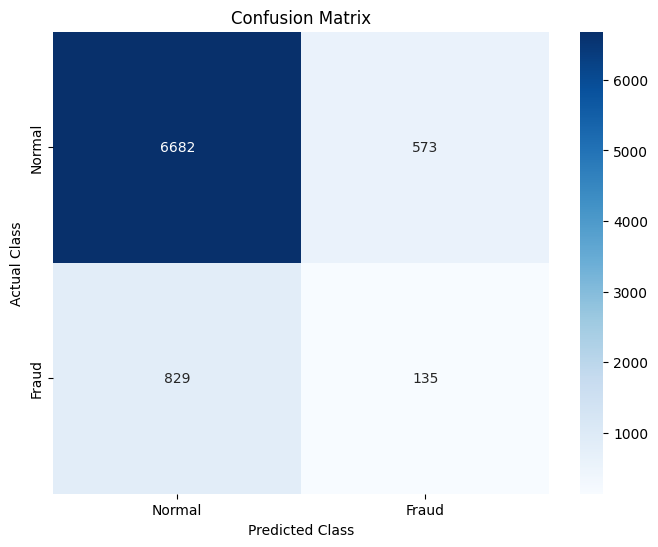

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

flow_model = create_nflows_model(input_dim, num_coupling_layers, hidden_dim)

if os.path.exists(best_model_path):
    print(f"\nLoading best model from '{best_model_path}' for evaluation.")
    state_dict = torch.load(best_model_path, map_location=device)

    # Handle the 'module.' prefix if the model was saved using DataParallel
    if next(iter(state_dict)).startswith('module.'):
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
        flow_model.load_state_dict(new_state_dict)
    else:
        flow_model.load_state_dict(state_dict)
else:
    print("\nWarning: No saved model found. Cannot perform evaluation.")
    exit()
    
flow_model.to(device)
flow_model.eval()

def detect_anomalies(model, data_loader, full_train_data_tensor, threshold_percentile=5):
    """Calculates log probabilities and flags anomalies."""
    model.eval()
    log_probs_list = []

    with torch.no_grad():
        for (batch,) in data_loader:
            batch = batch.to(device)
            log_probs = model.log_prob(inputs=batch)
            log_probs_list.append(log_probs.cpu())

    log_probs_tensor = torch.cat(log_probs_list)

    # Use the full training data to set a robust threshold
    with torch.no_grad():
        train_log_probs = model.log_prob(inputs=full_train_data_tensor.to(device))

    threshold = np.percentile(train_log_probs.cpu().numpy(), threshold_percentile)
    print(f"\nAnomaly threshold (log probability): {threshold:.4f}")

    predictions = log_probs_tensor.numpy() < threshold
    return predictions, log_probs_tensor.numpy()

test_dataset_encoded = TensorDataset(torch.from_numpy(X_test_encoded.astype(np.float32)))
test_loader_encoded = DataLoader(test_dataset_encoded, batch_size=batch_size)

full_train_tensor_encoded = torch.from_numpy(X_train_encoded.astype(np.float32))

anomaly_predictions, log_probabilities = detect_anomalies(flow_model, test_loader_encoded, full_train_tensor_encoded, threshold_percentile=5)

# --- Performance Metrics ---
correct_predictions = (anomaly_predictions == y_test)
accuracy = np.mean(correct_predictions)
true_positives = np.sum(anomaly_predictions & (y_test == 1))
false_positives = np.sum(anomaly_predictions & (y_test == 0))
recall = true_positives / np.sum(y_test == 1) if np.sum(y_test == 1) > 0 else 0

print("\n--- Performance Metrics ---")
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print(f"Fraud cases detected (Recall): {recall * 100:.2f}% ({true_positives}/{np.sum(y_test==1)})")
print(f"Normal cases flagged as fraud (False Positives): {false_positives}/{np.sum(y_test==0)}")

print("\n--- Classification Report ---")
print(classification_report(y_test, anomaly_predictions, target_names=['Normal', 'Fraud']))

auc_score = roc_auc_score(y_test, 1 - log_probabilities) # Use 1-prob for AUC scoring
print(f"ROC AUC Score: {auc_score:.4f}")

cm = confusion_matrix(y_test, anomaly_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()